# Linear Dataset Dimensionality Reduction

### Setup

In [47]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir('..')

print("Current working directory: ", os.getcwd())
if not os.getcwd().endswith("Dimensionality-Reduction-Notebooks"):
    raise ValueError("Please change working directory to 'path/Dimensionality-Reduction-Notebooks' before proceeding")

Current working directory:  /Users/irellzane/MLprojects/Dimensionality-Reduction-Notebooks


In [48]:
%pip install -r requirements.txt

  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached scikit_learn-1.4.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached matplotlib-3.8.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.13.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.2.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (159 kB)
  Using cac

In [49]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Dataset

#### Oval shaped dataset in 3D

In [50]:
np.random.seed(42)

m = 60
X = np.zeros((m, 3))
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5

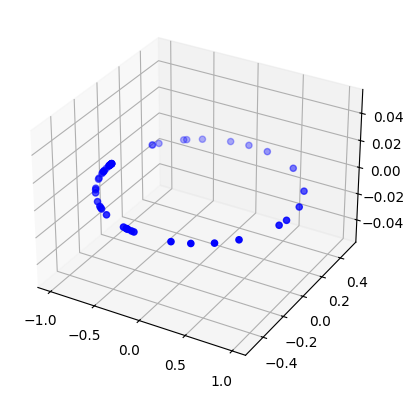

In [51]:

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', marker='o')

plt.show()